# Autoencoder for Recommendation Systems
---

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [39]:
ratings = pd.read_csv('ratings.dat',
                 sep='::',
                 engine='python',
                 encoding='latin-1',
                 names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pd.read_csv('movies.dat',
                    sep='::',
                    engine='python',
                    encoding='latin-1',
                    names=['movieid', 'title', 'genre']).set_index("movieid")

In [40]:
rating_counts = ratings.groupby("movieid")["rating"].count().sort_values(ascending=False)

# only the 500 most popular movies
pop_ratings = ratings[ratings["movieid"].isin((rating_counts).index[0:500])]
pop_ratings = pop_ratings.set_index(["movieid", "userid"])

In [75]:
pop_ratings.head()

,,rating,timestamp
movieid,userid,,
185,1,5.0,838983525
231,1,5.0,838983392
292,1,5.0,838983421
316,1,5.0,838983392
329,1,5.0,838983392


In [41]:
prefs = pop_ratings["rating"]

mean_0 = pop_ratings["rating"].mean()
prefs = prefs - mean_0

mean_i = prefs.groupby("movieid").mean()
prefs = prefs - mean_i

mean_u = prefs.groupby("userid").mean()
prefs = prefs - mean_u


pref_matrix = prefs.reset_index()[["userid", "movieid", "rating"]].pivot(index="userid", columns="movieid", values="rating")

In [42]:
pref_matrix.head()

movieid,1,2,3,5,6,7,10,11,16,17,19,21,22,25,31,32,34,36,39,44,45,47,48,50,52,58,62,70,95,104,105,110,111,112,141,145,150,151,153,158,...,4886,4896,4963,4973,4979,4993,4995,5010,5060,5218,5299,5349,5378,5418,5445,5502,5618,5669,5816,5952,5989,6333,6365,6377,6539,6711,6874,6934,7147,7153,7361,7438,8360,8368,8636,8665,8961,32587,33493,33794
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.275927,NaN,NaN,NaN,NaN,NaN,-0.175804,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398555,NaN,NaN,NaN,NaN,NaN,0.946824,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.574418,NaN,NaN,NaN,-0.523333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.639459,NaN,NaN,NaN,0.066872,1.086075,NaN,NaN,NaN,NaN,-0.174319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.237617,NaN,NaN,NaN,NaN,0.653951,NaN,-1.06853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.276905,NaN,NaN,NaN,NaN,0.471945,NaN,1.443146,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-2.778443,NaN,NaN,NaN,NaN,-0.214692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.534966,NaN,1.275259,NaN,NaN,NaN,NaN,NaN,1.119088,NaN,NaN,0.605906,-0.860968,NaN,NaN,NaN,NaN,NaN,NaN,0.018223,NaN,-0.371386,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
pref_matrix.fillna(0, inplace=True)

In [44]:
def sparsity_calculation(data):
    data = np.nan_to_num(data)
    return round(1. - np.count_nonzero(data) / data.size, 3) * 100

In [45]:
sparsity_calculation(pref_matrix)

85.6

(69755, 500)

In [50]:
model = tf.keras.Sequential([
    #encoder
    tf.keras.layers.Dense(units=256, activation='tanh', name='enc_1', input_dim=pref_matrix.shape[1]),
    tf.keras.layers.BatchNormalization(name='batch_1'),
    tf.keras.layers.Dense(units=128, activation='tanh', name='enc_2'),
    tf.keras.layers.BatchNormalization(name='batch_2'),
    tf.keras.layers.Dropout(0.5, name='drop_2'),

    #bottleneck
    tf.keras.layers.Dense(units=32, activation='linear', name='embeddings'),

    #decoder
    tf.keras.layers.Dense(units=128, activation='tanh', name='dec_1'),
    tf.keras.layers.Dense(units=pref_matrix.shape[1], activation='linear', name='user_rating_pred')
])

In [53]:
model.compile(optimizer='adam', loss='mse')

In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', verbose=1)

In [55]:
history = model.fit(
    pref_matrix,
    pref_matrix,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[callback]
)

Epoch 1/50
1962/1962 [==============================] - 14s 6ms/step - loss: 0.0943 - val_loss: 0.0892
Epoch 2/50
1962/1962 [==============================] - 13s 6ms/step - loss: 0.0878 - val_loss: 0.0875
Epoch 3/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0868 - val_loss: 0.0865
Epoch 4/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0864 - val_loss: 0.0868
Epoch 5/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0861 - val_loss: 0.0896
Epoch 6/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0859 - val_loss: 0.0929
Epoch 7/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0859 - val_loss: 0.0943
Epoch 8/50
1962/1962 [==============================] - 12s 6ms/step - loss: 0.0858 - val_loss: 0.0894
Epoch 00008: early stopping


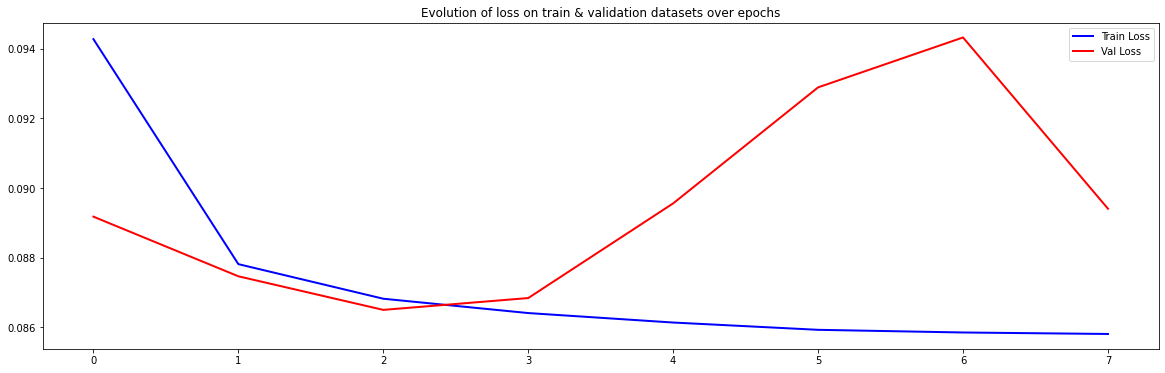

In [57]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.plot(epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

In [58]:
predictions = model.predict(pref_matrix)

In [62]:
predictions = pd.DataFrame(predictions, columns=pref_matrix.columns, index=pref_matrix.index)

In [64]:
predictions.head()

movieid,1,2,3,5,6,7,10,11,16,17,19,21,22,25,31,32,34,36,39,44,45,47,48,50,52,58,62,70,95,104,105,110,111,112,141,145,150,151,153,158,...,4886,4896,4963,4973,4979,4993,4995,5010,5060,5218,5299,5349,5378,5418,5445,5502,5618,5669,5816,5952,5989,6333,6365,6377,6539,6711,6874,6934,7147,7153,7361,7438,8360,8368,8636,8665,8961,32587,33493,33794
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.107300,-0.030339,0.039037,0.004706,0.002643,0.001783,0.020197,0.031308,0.018690,-0.050191,0.236483,0.027789,-0.002300,-0.122426,-0.012494,0.270090,0.062804,-0.034319,0.068037,0.001276,-0.011763,0.126733,-0.031493,0.024621,-0.000256,-0.022208,-0.032899,-0.045558,0.021086,0.182883,-0.034078,-0.068853,-0.013511,-0.015208,-0.029651,0.036127,0.025531,0.002905,-0.014930,-0.004465,...,0.013925,-0.007922,0.029293,0.000211,0.013585,-0.067951,0.010148,-0.009916,-0.014583,-0.004523,0.007893,0.050025,0.032069,0.011418,0.045676,0.034252,-0.010980,-0.008843,-0.009988,-0.048081,0.025124,0.012559,0.028117,-0.007385,-0.004700,-0.035483,-0.052558,0.025414,-0.003526,-0.060940,0.013253,-0.033015,0.005258,-0.008430,0.040010,0.008924,0.008745,-0.015215,0.037413,0.012865
2,0.240752,-0.020035,-0.001978,-0.035843,-0.052195,-0.026841,-0.082536,0.049303,-0.047958,-0.070754,0.117126,-0.027785,-0.031207,-0.071781,-0.027896,0.249850,0.171493,-0.050405,-0.028400,-0.038733,-0.047675,-0.210560,-0.013124,-0.148100,-0.029134,-0.008414,-0.012179,-0.023737,-0.099661,0.103956,0.005710,0.956993,-0.172548,-0.016490,-0.060443,-0.018239,0.222484,0.091837,-0.131673,-0.019310,...,-0.003515,-0.015442,-0.031465,-0.011372,-0.010243,-0.158384,0.007090,-0.015205,-0.058875,-0.035619,-0.006077,0.016528,0.102992,-0.032563,0.025797,0.050384,-0.041237,-0.001406,-0.035183,-0.130394,-0.007557,0.004533,0.045386,-0.035966,-0.021369,-0.060918,-0.050960,0.010437,-0.027752,-0.111772,-0.010478,-0.029023,-0.019130,-0.044656,0.008187,-0.027235,0.005080,-0.013743,0.079362,-0.014221
3,0.167764,-0.017545,0.019759,-0.006402,0.007377,0.001863,0.000828,0.037005,0.020680,-0.026266,0.108564,0.034651,-0.012077,-0.071655,-0.017263,0.356739,0.091085,-0.030287,0.054358,-0.018320,-0.019170,0.088480,0.000490,0.032384,-0.005412,-0.008577,-0.010460,-0.051407,-0.028619,0.099117,-0.034902,0.266776,-0.047816,-0.021143,-0.014198,0.010069,0.088018,0.015993,0.020160,-0.011033,...,0.034209,-0.025800,0.021380,0.013698,0.002410,-0.300662,0.041629,-0.007298,-0.013522,-0.006285,0.012063,-0.007416,0.031567,0.001695,0.054304,0.016411,-0.034997,-0.003372,-0.028964,-0.256247,0.037441,-0.011867,0.022357,-0.000520,-0.040626,-0.037445,-0.046762,0.005489,0.005018,-0.239915,0.015570,-0.031023,0.009214,-0.035889,-0.002040,-0.000916,0.005256,-0.010024,0.024106,-0.003800
4,0.226458,0.111735,0.007168,0.018222,-0.089289,0.019076,0.034576,0.072463,0.033637,-0.008831,-0.485210,-0.102414,-0.052964,-0.125835,0.002521,0.262838,0.365648,-0.014728,-0.202074,-0.020779,-0.006305,0.099320,0.119397,-0.070368,-0.018493,-0.019808,0.090516,-0.081954,-0.150086,-0.087181,0.021387,0.061482,-0.044738,-0.041240,-0.006835,-0.075608,0.241306,0.053886,0.457166,0.048994,...,0.054807,0.017638,-0.038006,-0.032893,-0.052158,-0.174347,-0.005206,0.015395,0.017952,-0.027911,-0.002998,0.007563,0.078661,-0.037830,0.030656,0.012319,-0.036755,-0.024703,0.010996,-0.103939,-0.003449,0.022572,0.014749,-0.010205,-0.017293,0.005253,-0.039524,0.012736,-0.002996,-0.109195,-0.019489,-0.017291,-0.013864,-0.014955,0.001950,-0.014549,-0.013638,0.012030,0.031169,0.002439
5,-1.177195,-0.210931,-0.048828,-0.102632,0.246066,-0.059744,0.040290,-0.101496,0.145077,0.172697,0.072355,0.132947,-0.037946,0.292671,-0.080762,1.528702,0.274744,0.219845,0.123112,-0.135780,0.076954,0.340863,-0.025112,0.202203,0.107349,0.128455,-0.198121,-0.112171,-0.239652,0.046908,-0.046383,-0.173685,0.125134,-0.022102,-0.049031,-0.044311,-0.088149,0.039564,-0.324026,-0.105470,...,-0.140880,-0.027222,-0.003323,-0.001741,0.030761,-0.110153,0.052446,-0.000491,0.052691,-0.041220,0.01

In [143]:
def recommend_for_user(real_user_item_matrix, pred_user_item_matrix, content_data, user_id, top_n):

  ratings_df = real_user_item_matrix.loc[user_idx].to_frame('ratings').join(pred_user_item_matrix.loc[user_idx].to_frame('pred_ratings'))
  recs_df = ratings_df[ratings_df['ratings'] == 0].sort_values(by='pred_ratings', ascending=False).drop('ratings', axis=1)
  watch_df = ratings_df[ratings_df['ratings'] != 0].sort_values(by='ratings', ascending=False).drop('pred_ratings', axis=1)

  recs_df = recs_df.join(content_data).head(top_n)
  watch_df = watch_df.join(content_data).head(top_n)

  return recs_df, watch_df

In [149]:
user_idx = 4
top_n = 20

recs_df, watch_df = recommend_for_user(real_user_item_matrix=pref_matrix, pred_user_item_matrix=predictions, content_data=movies, user_id=user_id, top_n=top_n)

In [152]:
print('RECOMMENDATIONS:')
display(recs_df)
print('=' * 100)
print('WATCH LIST:')
display(watch_df)

RECOMMENDATIONS:


,pred_ratings,title,genre
movieid,,,
780,0.402108,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|War
1270,0.303761,Back to the Future (1985),Adventure|Comedy|Sci-Fi
32,0.262838,12 Monkeys (Twelve Monkeys) (1995),Sci-Fi|Thriller
2683,0.259171,Austin Powers: The Spy Who Shagged Me (1999),Action|Adventure|Comedy
1356,0.255863,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
2012,0.233556,Back to the Future Part III (1990),Comedy|Sci-Fi|Western
1374,0.227086,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller
1,0.226458,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2716,0.217349,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Fantasy|Sci-Fi


WATCH LIST:


,ratings,title,genre
movieid,,,
153,1.443146,Batman Forever (1995),Action|Adventure|Comedy|Crime
410,1.383039,Addams Family Values (1993),Comedy
586,1.301728,Home Alone (1990),Children|Comedy
317,1.203500,"Santa Clause, The (1994)",Comedy|Drama|Fantasy
329,1.023024,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
316,1.009942,Stargate (1994),Action|Adventure|Sci-Fi
592,0.972738,Batman (1989),Action|Crime|Sci-Fi|Thriller
500,0.950192,Mrs. Doubtfire (1993),Comedy|Drama
587,0.906725,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
